In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [3]:
os.chdir(os.path.dirname(working_dir))

In [4]:
working_dir = os.getcwd()
print(f"You have now changed your working directory to {working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN


In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


In [6]:
image_dirs = 'inputs/dataset/resized_mean_value/flower_photos'
train_path = image_dirs + '/train'
val_path = image_dirs + '/validation'
test_path = image_dirs + '/test'

In [7]:
labels = os.listdir(train_path)

print(f"Flower labels: {labels}")

Flower labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [8]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/mean_image_shape.pkl")
image_shape

(271, 365, 3)

<hr>

## Image distribution through the sets


* train - daisy: 3544 images
* train - dandelion: 5028 images
* train - roses: 3589 images
* train - sunflowers: 3914 images
* train - tulips: 4474 images
* validation - daisy: 506 images
* validation - dandelion: 718 images
* validation - roses: 512 images
* validation - sunflowers: 559 images
* validation - tulips: 639 images
* test - daisy: 1014 images
* test - dandelion: 1438 images
* test - roses: 1027 images
* test - sunflowers: 1119 images
* test - tulips: 1279 images




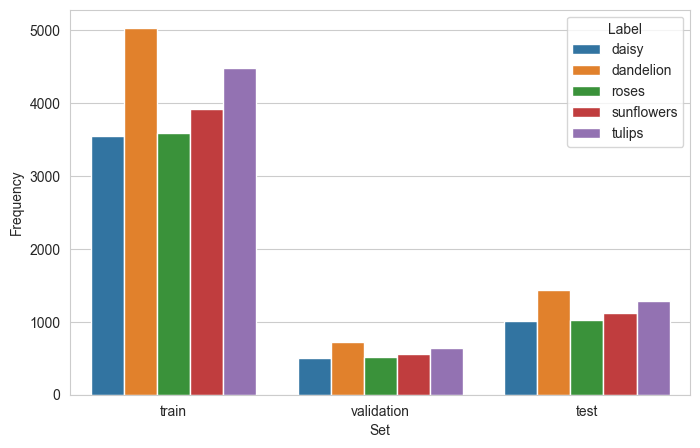

In [9]:
data = []


for folder in ['train', 'validation', 'test']:
    for label in labels:
        
        data.append({
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(image_dirs + '/' + folder + '/' + label)))
        })
        
        print(f"* {folder} - {label}: {len(os.listdir(image_dirs + '/' + folder + '/' + label))} images")


df_freq = pd.DataFrame(data)


print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

<hr>

## Image Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [12]:
batch_size = 20 
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 20549 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 2934 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 5877 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

(20, 271, 365, 3)


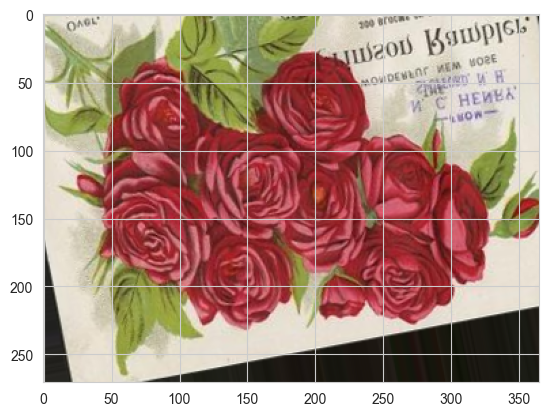

In [15]:
for _ in range(1):
    img, label = next(train_set)  
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

(20, 271, 365, 3)


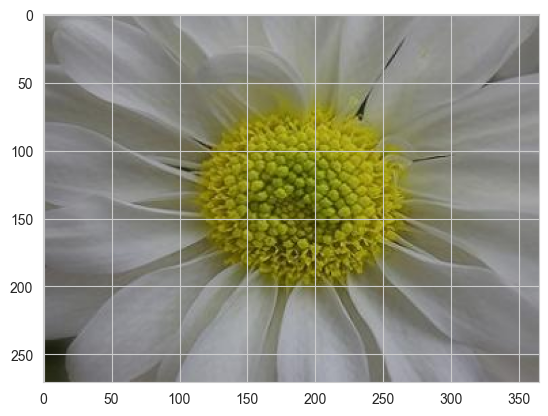

In [16]:
for _ in range(1):
    img, label = next(validation_set)  
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

In [17]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_model():
    input_shape = (365, 271, 3)  
    num_classes = 5  

    # Creates a sequential model
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation='softmax'))  

    # Compiles the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Show the model architecture
    model.summary()
    
    return model  




In [ ]:
def create_tf_model(): # from CI Walkthrough
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
model = create_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

In [ ]:
model.save('outputs/v1/flower_detector.h5')